In [20]:
# Importando as bibliotecas necessárias
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.callbacks import EarlyStopping
from keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

# Configurando o matplotlib
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 4]

In [30]:
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is None:
            warnings.warn('Can save best model only with val_accuracy available, skipping.')
        else:
            try:
                # Load the saved model
                saved_model = load_model(self.filepath)

                # Evaluate the saved model on the validation set
                saved_val_loss, saved_val_acc = saved_model.evaluate(x_val, y_val, verbose=0)

                # If the new model is better, save it
                if val_accuracy > saved_val_acc:
                    self.model.save(self.filepath)
                    print('Epoch', epoch+1, ': found a better model with validation accuracy', val_accuracy)
            except Exception:
                # If there is no saved model yet, save the new model
                self.model.save(self.filepath)
                print('Epoch', epoch+1, ': found the first model with validation accuracy', val_accuracy)


In [22]:
# Download
# https://www.dropbox.com/s/8o4ysiccspp46ov/skin-cancer-mnist-ham10000.zip?dl=1

# Load the metadata
metadata = pd.read_csv('data/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Print the first 5 rows of the metadata
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [23]:
# Preparação dos dados

# Carregar as imagens e os rótulos
images = []
labels = []

# Caminho para as imagens
image_path = 'data/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'

# Loop através de todas as imagens no diretório
for img in os.listdir(image_path):
    # Carregar a imagem
    image = Image.open(image_path + img)
    # Redimensionar a imagem para 32x32 pixels
    image = image.resize((32, 32))
    # Converter a imagem para array numpy
    image = np.array(image)
    # Adicionar a imagem à lista de imagens
    images.append(image)

    # Adicionar o rótulo à lista de rótulos
    labels.append(metadata[metadata['image_id'] == img.split('.')[0]]['dx'].values[0])

# Converter listas em arrays numpy
images = np.array(images)
labels = np.array(labels)

# Print the shape of the images and labels
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)

Images shape: (5000, 32, 32, 3)
Labels shape: (5000,)


In [24]:
# Codificar os rótulos
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# Dividir os dados em conjuntos de treinamento, validação e teste
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Print the shape of the train, validation and test sets
print('Train set shape:', x_train.shape, y_train.shape)
print('Validation set shape:', x_val.shape, y_val.shape)
print('Test set shape:', x_test.shape, y_test.shape)

Train set shape: (2800, 32, 32, 3) (2800, 7)
Validation set shape: (700, 32, 32, 3) (700, 7)
Test set shape: (1500, 32, 32, 3) (1500, 7)


In [25]:
# Definindo a arquitetura da rede
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
model_checkpoint = CustomModelCheckpoint('best_model.h5')

# Compilando o modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [31]:
# Treinando o modelo
history = model.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
    )

Epoch 1/1000
175/175 [==============================] - 2s 13ms/step - loss: 0.4075 - accuracy: 0.8604 - val_loss: 1.0445 - val_accuracy: 0.7186
Epoch 2/1000
175/175 [==============================] - 2s 12ms/step - loss: 0.3258 - accuracy: 0.8861 - val_loss: 1.2738 - val_accuracy: 0.7186
Epoch 3/1000
175/175 [==============================] - 2s 12ms/step - loss: 0.3363 - accuracy: 0.8832 - val_loss: 1.4336 - val_accuracy: 0.7057
Epoch 4/1000
175/175 [==============================] - 2s 12ms/step - loss: 0.3275 - accuracy: 0.8832 - val_loss: 1.3945 - val_accuracy: 0.6957
Epoch 5/1000
175/175 [==============================] - 2s 12ms/step - loss: 0.2759 - accuracy: 0.9054 - val_loss: 1.3760 - val_accuracy: 0.7157
Epoch 6/1000
175/175 [==============================] - 2s 12ms/step - loss: 0.2358 - accuracy: 0.9179 - val_loss: 1.4408 - val_accuracy: 0.7229
Epoch 7/1000
175/175 [==============================] - 2s 12ms/step - loss: 0.1980 - accuracy: 0.9282 - val_loss: 1.5766 - val_ac

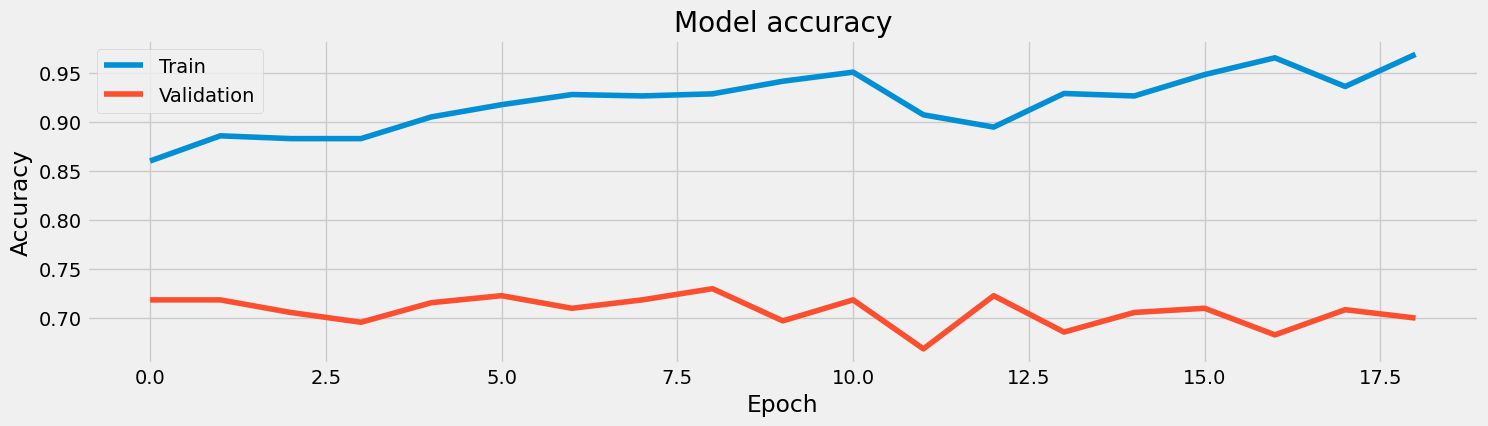

In [32]:
# Plotando a acurácia de treinamento e validação ao longo das épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [33]:
# Load the saved model
best_model = load_model('best_model.h5')

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

47/47 [==============================] - 1s 25ms/step - loss: 0.6535 - accuracy: 0.7687
Test accuracy: 0.768666684627533


# Modificações para Melhorar a Acurácia de Validação

Vamos implementar algumas modificações no modelo original para tentar melhorar a acurácia de validação. As modificações incluem:

1. **Aumento de dados (Data Augmentation)**: Vamos criar versões modificadas das imagens de treinamento, como rotações, translações, zoom e flip horizontal.

2. **Regularização**: Vamos adicionar regularização ao nosso modelo para evitar o overfitting. Isso será feito adicionando camadas de dropout após as camadas convolucionais e/ou densas.

3. **Ajuste de hiperparâmetros**: Vamos experimentar diferentes configurações de hiperparâmetros, como a taxa de aprendizado do otimizador, o número de unidades nas camadas densas, o tamanho do lote e o número de épocas.

4. **Arquitetura da rede**: Vamos adicionar mais camadas convolucionais e alterar o número de filtros nas camadas convolucionais existentes.

5. **Função de ativação**: Vamos experimentar diferentes funções de ativação, como ReLU, LeakyReLU ou ELU.

6. **Normalização de lote**: Vamos adicionar normalização de lote após as camadas convolucionais para acelerar o treinamento e melhorar a performance do modelo.

## Aumento de Dados (Data Augmentation)

Vamos começar com o aumento de dados. O aumento de dados é uma técnica que permite gerar mais dados de treinamento a partir do nosso conjunto de dados existente, aplicando várias transformações que produzem imagens semelhantes. Isso inclui coisas como rotações, translações, zoom e flip horizontal.

O aumento de dados pode ajudar a melhorar o desempenho do modelo e reduzir o overfitting.

In [34]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest')

# Fit the ImageDataGenerator object to our training data
datagen.fit(x_train)

## Regularização

A regularização é uma técnica usada para evitar o overfitting, que é quando o modelo aprende tão bem os dados de treinamento que se torna ruim em generalizar para dados não vistos. Uma forma comum de regularização é o dropout, onde aleatoriamente um número de saídas de neurônios na camada são ignorados durante o treinamento. Isso ajuda a garantir que o modelo não dependa muito de qualquer neurônio individual e, portanto, tenha uma melhor capacidade de generalização.

## Ajuste de Hiperparâmetros

Os hiperparâmetros são os parâmetros que definem a configuração do processo de treinamento. Por exemplo, a taxa de aprendizado é um hiperparâmetro que determina a rapidez com que o modelo aprende. Outros hiperparâmetros incluem o número de unidades nas camadas densas, o tamanho do lote e o número de épocas.

Vamos experimentar diferentes configurações de hiperparâmetros para ver se podemos melhorar a acurácia de validação.

## Arquitetura da Rede

A arquitetura da rede se refere à configuração das camadas em nossa rede neural. Isso inclui o número de camadas, o número de neurônios em cada camada e como essas camadas estão conectadas. Vamos experimentar adicionar mais camadas convolucionais e alterar o número de filtros nas camadas convolucionais existentes para ver se podemos melhorar a acurácia de validação.

## Função de Ativação

A função de ativação determina a saída de um neurônio com base em sua entrada. Funções de ativação comuns incluem ReLU, sigmoid e tanh. Vamos experimentar diferentes funções de ativação para ver se podemos melhorar a acurácia de validação.

## Normalização de Lote

A normalização de lote é uma técnica que pode acelerar o treinamento, melhorar a performance do modelo e proporcionar uma forma de regularização. Ela funciona normalizando a entrada para cada mini-lote para ter uma média de zero e uma variância de um. Isso é tipicamente feito inserindo camadas de normalização de lote após as camadas convolucionais em nossa rede.

In [35]:
# Define the model
model = Sequential()

# Add the convolutional layers
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Add the dense layers
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Agora que fizemos todas as modificações sugeridas, vamos treinar o modelo e ver se a acurácia de validação melhorou.

In [41]:
# Train the model
hist = model.fit(
    datagen.flow(x_train, y_train, batch_size=8),
    epochs=1000,
    validation_data=(x_test, y_test),
    workers=4,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
    )

Epoch 1/1000
350/350 [==============================] - 11s 32ms/step - loss: 0.7998 - accuracy: 0.7064 - val_loss: 0.8833 - val_accuracy: 0.6993
Epoch 2/1000
350/350 [==============================] - 10s 28ms/step - loss: 0.7682 - accuracy: 0.7204 - val_loss: 0.9078 - val_accuracy: 0.6980
Epoch 3/1000
350/350 [==============================] - 10s 29ms/step - loss: 0.7658 - accuracy: 0.7246 - val_loss: 0.8720 - val_accuracy: 0.7187
Epoch 4/1000
350/350 [==============================] - 11s 31ms/step - loss: 0.7798 - accuracy: 0.7089 - val_loss: 0.9143 - val_accuracy: 0.7180
Epoch 5/1000
350/350 [==============================] - 11s 31ms/step - loss: 0.7434 - accuracy: 0.7321 - val_loss: 0.7685 - val_accuracy: 0.7280
Epoch 6/1000
350/350 [==============================] - 10s 29ms/step - loss: 0.7078 - accuracy: 0.7282 - val_loss: 0.7160 - val_accuracy: 0.7267
Epoch 7/1000
350/350 [==============================] - 10s 29ms/step - loss: 0.7206 - accuracy: 0.7393 - val_loss: 0.7820 -

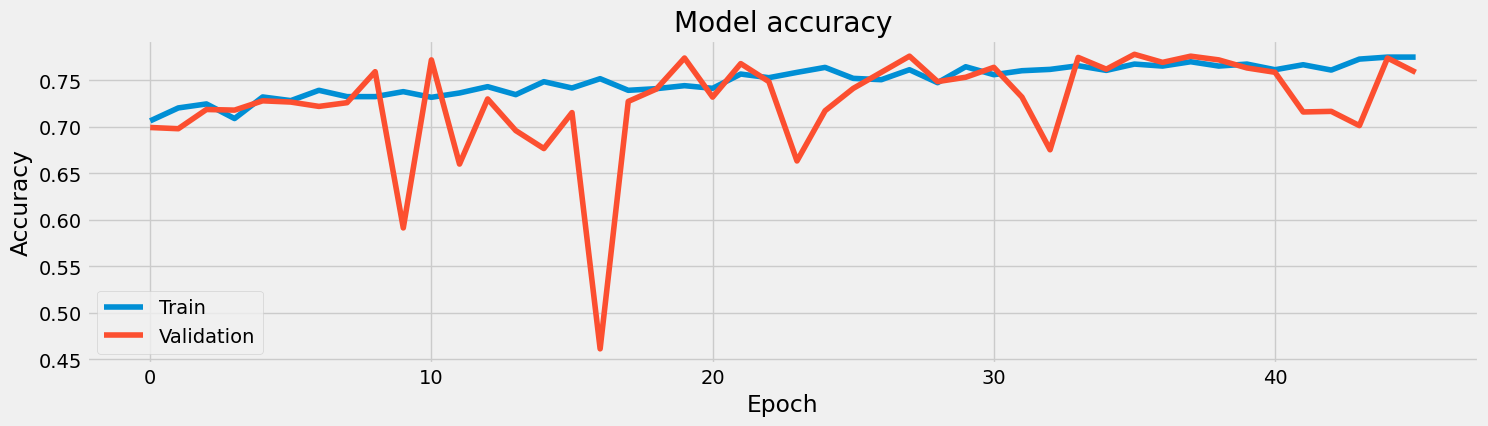

In [42]:
# Plotando a acurácia de treinamento e validação ao longo das épocas
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [43]:
# Load the saved model
best_model = load_model('best_model.h5')

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

47/47 [==============================] - 2s 31ms/step - loss: 0.6389 - accuracy: 0.7747
Test accuracy: 0.7746666669845581


# Plot

1/1 [==============================] - 0s 31ms/step


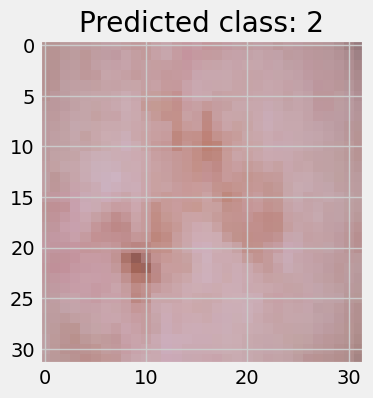

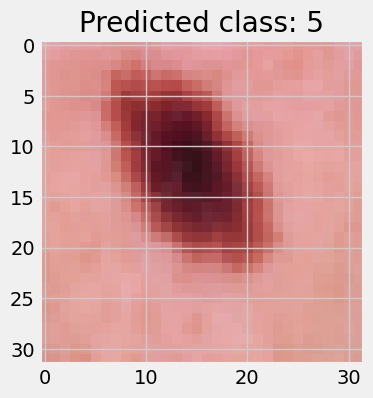

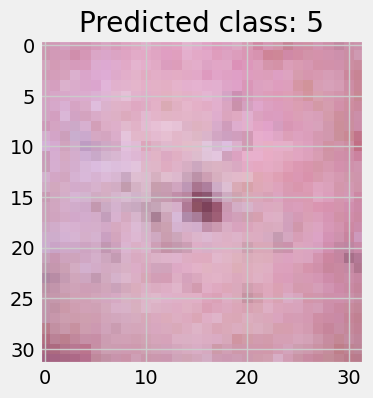

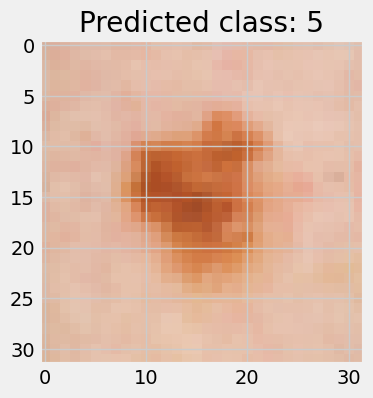

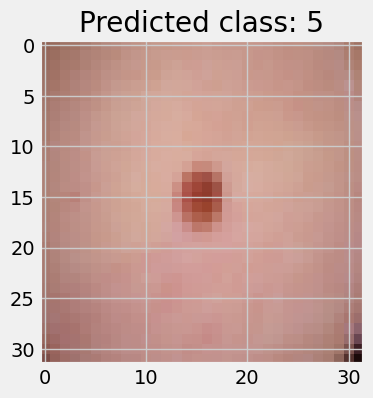

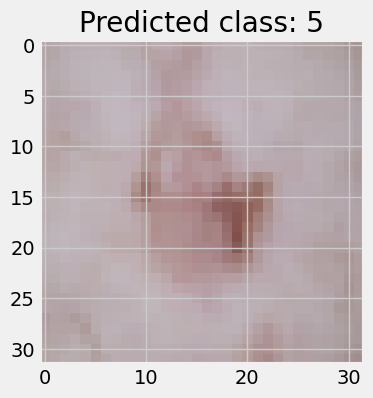

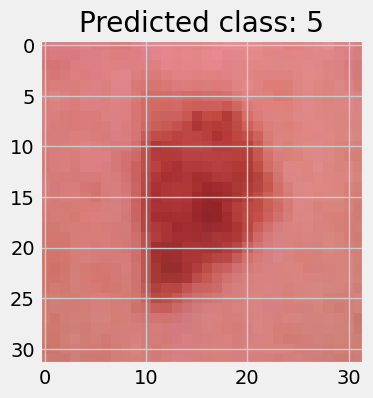

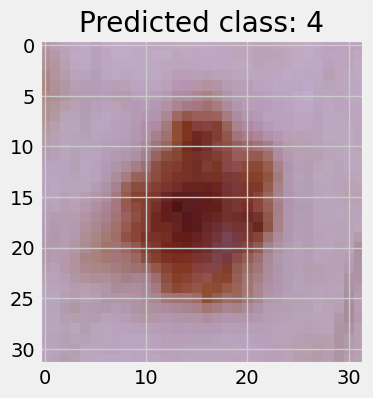

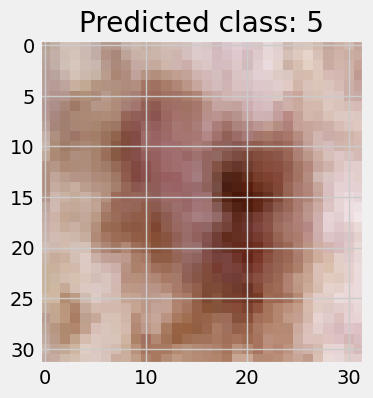

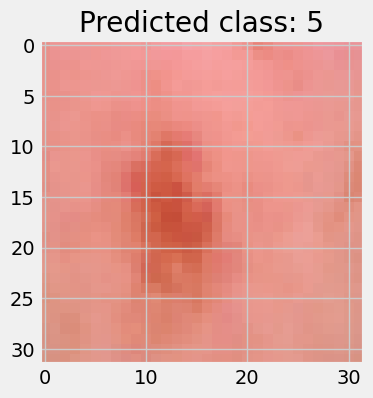

In [47]:
# Generate 10 random indices
indices = np.random.choice(range(x_test.shape[0]), size=10, replace=False)

# Select the random images and labels
random_images = x_test[indices]
random_labels = y_test[indices]

# Generate predictions for the random images
predictions = model.predict(random_images)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Plot the images and their predicted classes
for i in range(10):
    plt.imshow(random_images[i])
    plt.title(f'Predicted class: {str(predicted_classes[i])}')
    plt.show()
